In [1]:
import os
import sys
sys.path.append(os.path.abspath('..'))

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
import modules.rcnn.net as net
import modules.rcnn.shapes as shapes
import modules.rcnn.box as box

In [2]:
H = 20
W = 20
h = H-1
w = W-1

n_min = 2
n_max = 6

x, shap = shapes.get_random_shapes(n_min,n_max,H,W)

gt_box, gt_label = shapes.shapes_to_gt(shap)
print(gt_box)
print(gt_label)

[[0.77649712 0.75       0.10074222 0.22073276]
 [0.22913214 0.25       0.35853109 0.35853109]]
[0. 2.]


In [3]:
anchor_boxes = np.array([
    [0.3,0.3],
    [0.2,0.2],
    [0.1,0.1],
    [0.05,0.05],
])

K = anchor_boxes.shape[0]

anchors = np.zeros((H,W,K,4))

for i in range(H):
    for j in range(W):
        anchors[i,j,:,0] = (j+0.5)/W
        anchors[i,j,:,1] = (i+0.5)/H
        anchors[i,j,:,2] = anchor_boxes[:,0]
        anchors[i,j,:,3] = anchor_boxes[:,1]
        
anchors_1d = anchors.reshape((-1,4))

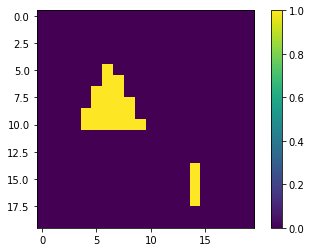

In [4]:
plt.figure()
plt.imshow(x)
plt.colorbar()
plt.show()

In [5]:
Ntrain     = 10000
lr         = 0.001
print_step = 1000

In [6]:
x_tf       = tf.placeholder(shape=[1,H,W,1], dtype=tf.float32)
y_box_tf   = tf.placeholder(shape=[H*W*K,4], dtype=tf.float32)
y_label_tf = tf.placeholder(shape=[H*W*K], dtype=tf.float32)
y_weights_tf = tf.placeholder(shape=[H*W*K], dtype=tf.float32)

backbone = net.Backbone(input_channels=1, output_size=64)
rpn      = net.RPN(backbone, num_boxes=K, backbone_channels=64, 
                   window_size=10, hidden_size=256)

rpn_obj_logits, rpn_obj, rpn_box = rpn(x_tf)

list_box        = tf.reshape(rpn_box, shape=[-1,4])
list_obj_logits = tf.reshape(rpn_obj_logits, shape=[-1])
list_obj        = tf.reshape(rpn_obj, shape=[-1])

loss_class = tf.reduce_mean(y_weights_tf*tf.nn.sigmoid_cross_entropy_with_logits(labels=y_label_tf, 
                                         logits=list_obj_logits))

loss_box   = tf.reduce_mean(y_weights_tf*y_label_tf*(tf.reduce_sum(tf.square(list_box - y_box_tf), axis=1)))

loss = loss_class+loss_box

print(loss_class, loss_box, loss)

W0809 14:40:48.961618 139841112975104 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W0809 14:40:48.963557 139841112975104 deprecation_wrapper.py:119] From /home/marsdenlab/projects/centerline_detection/modules/rcnn/net.py:13: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0809 14:40:48.964409 139841112975104 deprecation_wrapper.py:119] From /home/marsdenlab/projects/centerline_detection/modules/layers_new.py:35: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0809 14:40:49.031344 139841112975104 deprecation.py:323] From /home/marsdenlab/anaconda3/lib/python3.6/site-packages/tens

Tensor("Mean:0", shape=(), dtype=float32) Tensor("Mean_1:0", shape=(), dtype=float32) Tensor("add:0", shape=(), dtype=float32)


In [7]:
opt = tf.train.AdamOptimizer(lr)
train_op = opt.minimize(loss)

In [8]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [9]:
for i in range(Ntrain):
    
    x, shap = shapes.get_random_shapes(n_min,n_max,H,W)
    
    gt_box, gt_label = shapes.shapes_to_gt(shap)
    
    gt_t, gt_matched, gt_labels, gt_weights =\
    box.create_box_gt(anchors_1d, gt_box)
    
    x = x.reshape((1,H,W,1))
    
    sess.run(train_op, {x_tf:x, y_box_tf:gt_t, y_label_tf:gt_labels, y_weights_tf:gt_weights})
    
    if i%print_step == 0:
        l = sess.run(loss, {x_tf:x, y_box_tf:gt_t, y_label_tf:gt_labels, y_weights_tf:gt_weights})
        
        print("iteration {}: loss={:.5f}".format(i,l))

iteration 0: loss=0.67131
iteration 1000: loss=0.00061
iteration 2000: loss=0.00019
iteration 3000: loss=0.00087
iteration 4000: loss=0.00008
iteration 5000: loss=0.00004
iteration 6000: loss=0.00034
iteration 7000: loss=0.00035
iteration 8000: loss=0.00153
iteration 9000: loss=0.00001


In [10]:
out_box, l_box, out_obj = sess.run([rpn_box, list_box, rpn_obj], {x_tf:x})

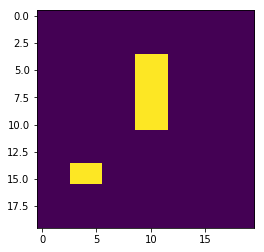

0


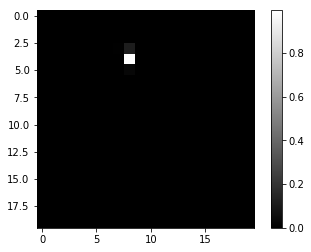

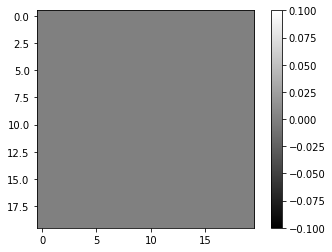

1


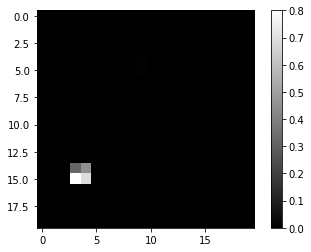

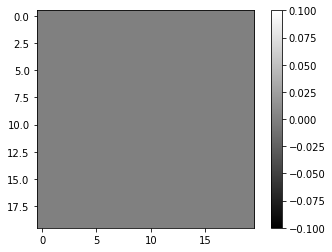

2


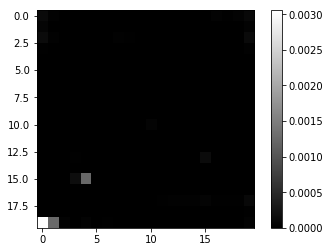

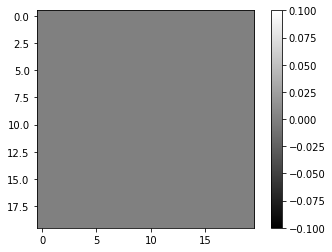

3


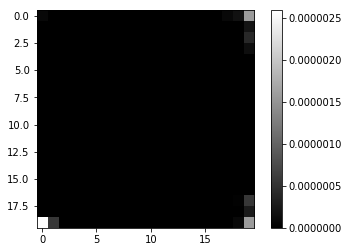

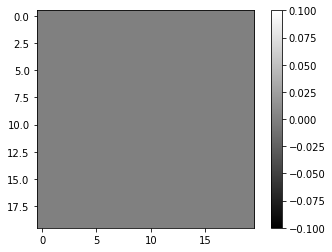

weights
0


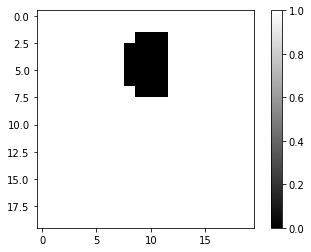

1


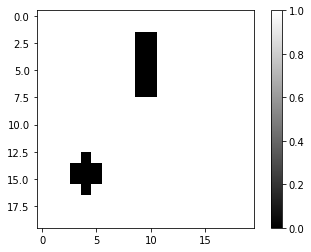

2


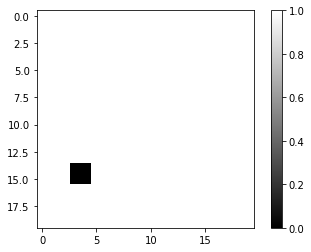

3


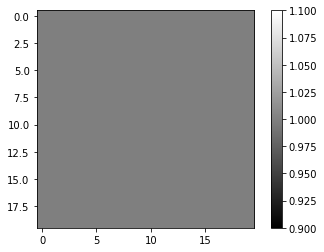

In [11]:
lab = gt_labels.reshape((H,W,K))
weights = gt_weights.reshape((H,W,K))

plt.figure()
plt.imshow(x[0,:,:,0])
plt.show()

for i in range(K):
    print(i)
    plt.figure()
    plt.imshow(out_obj[0,:,:,i], cmap='gray')
    plt.colorbar()
    plt.show()
    
    plt.figure()
    plt.imshow(lab[:,:,i], cmap='gray')
    plt.colorbar()
    plt.show()
    
print("weights")
for i in range(K):
    print(i)
    plt.figure()
    plt.imshow(weights[:,:,i], cmap='gray')
    plt.colorbar()
    plt.show()

In [12]:
print(np.sum(lab))
for i in range(K):
    print(i, np.sum(lab[:,:,i]))
    print(np.amax(lab[:,:,i]))

0.0
0 0.0
0.0
1 0.0
0.0
2 0.0
0.0
3 0.0
0.0


In [13]:
print(l_box[0])
print(gt_t[0])

[0.9999999  0.99996054 0.99925476 0.43915465]
[ 0.60671532  2.41666667 -0.4779896  -0.91058244]
